In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [3]:
# Load dataset
train_dataset = ImageFolder(root=r"D:\PlantDIsease\PDMD - RFS70\train", transform=transform)
val_dataset = ImageFolder(root=r"D:\PlantDIsease\PDMD - RFS70\val", transform=transform)
test_dataset = ImageFolder(root=r"D:\PlantDIsease\PDMD - RFS70\test", transform=transform)

In [4]:
# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
# from torchvision.models._api import WeightsEnum
# from torch.hub import load_state_dict_from_url

# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict

# efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# efficientnet_b0(weights="DEFAULT")

# Define EfficientNet model
model = models.vgg19(pretrained=True)

C:\Users\Welcome\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Welcome\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Welcome/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 548M/548M [00:49<00:00, 11.6MB/s]


In [6]:
# Display model summary
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [7]:
# Transfer model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
# Define loss function with label smoothing
class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = torch.nn.functional.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * \
            self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

In [9]:
criterion = SmoothCrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [10]:
# Training loop
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

In [11]:
best_val_acc = 0.0
for epoch in range(45):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Use tqdm for progress bar
    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/45', ncols=100)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_acc = correct_train / total_train
        pbar.set_postfix({'Train Loss': train_loss / (total_train / train_loader.batch_size), 'Train Acc': train_acc})
    
    train_loss_list.append(train_loss / len(train_loader))
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss_list.append(val_loss / len(val_loader))
    val_acc_list.append(correct_val / total_val)

    print(f'Epoch [{epoch + 1}/45], Train Loss: {train_loss_list[-1]:.4f}, Train Acc: {train_acc_list[-1]:.4f}, Val Loss: {val_loss_list[-1]:.4f}, Val Acc: {val_acc_list[-1]:.4f}')

    # Save model with best validation accuracy
    if val_acc_list[-1] > best_val_acc:
        best_val_acc = val_acc_list[-1]
        torch.save(model.state_dict(), 'vgg19_best_model.pth')

Epoch 1/45: 100%|█████████████| 1729/1729 [52:14<00:00,  1.81s/it, Train Loss=2.57, Train Acc=0.532]


Epoch [1/45], Train Loss: 2.5726, Train Acc: 0.5323, Val Loss: 2.2351, Val Acc: 0.6854


Epoch 2/45: 100%|█████████████| 1729/1729 [36:12<00:00,  1.26s/it, Train Loss=1.79, Train Acc=0.754]


Epoch [2/45], Train Loss: 1.7893, Train Acc: 0.7542, Val Loss: 2.1079, Val Acc: 0.7240


Epoch 3/45: 100%|█████████████| 1729/1729 [36:09<00:00,  1.25s/it, Train Loss=1.63, Train Acc=0.807]


Epoch [3/45], Train Loss: 1.6256, Train Acc: 0.8067, Val Loss: 1.9683, Val Acc: 0.7518


Epoch 4/45: 100%|█████████████| 1729/1729 [37:47<00:00,  1.31s/it, Train Loss=1.53, Train Acc=0.838]


Epoch [4/45], Train Loss: 1.5278, Train Acc: 0.8377, Val Loss: 2.0586, Val Acc: 0.7795


Epoch 5/45: 100%|█████████████| 1729/1729 [36:36<00:00,  1.27s/it, Train Loss=1.46, Train Acc=0.859]


Epoch [5/45], Train Loss: 1.4599, Train Acc: 0.8595, Val Loss: 1.9804, Val Acc: 0.7992


Epoch 6/45: 100%|█████████████| 1729/1729 [36:06<00:00,  1.25s/it, Train Loss=1.42, Train Acc=0.873]


Epoch [6/45], Train Loss: 1.4187, Train Acc: 0.8727, Val Loss: 1.9302, Val Acc: 0.7962


Epoch 7/45: 100%|█████████████| 1729/1729 [36:09<00:00,  1.26s/it, Train Loss=1.38, Train Acc=0.884]


Epoch [7/45], Train Loss: 1.3831, Train Acc: 0.8840, Val Loss: 1.9975, Val Acc: 0.7808


Epoch 8/45: 100%|█████████████| 1729/1729 [36:18<00:00,  1.26s/it, Train Loss=1.35, Train Acc=0.893]


Epoch [8/45], Train Loss: 1.3544, Train Acc: 0.8934, Val Loss: 1.9133, Val Acc: 0.8105


Epoch 9/45: 100%|█████████████| 1729/1729 [36:02<00:00,  1.25s/it, Train Loss=1.33, Train Acc=0.903]


Epoch [9/45], Train Loss: 1.3302, Train Acc: 0.9029, Val Loss: 1.9235, Val Acc: 0.8013


Epoch 10/45: 100%|█████████████| 1729/1729 [36:06<00:00,  1.25s/it, Train Loss=1.31, Train Acc=0.91]


Epoch [10/45], Train Loss: 1.3082, Train Acc: 0.9098, Val Loss: 1.8910, Val Acc: 0.8127


Epoch 11/45: 100%|████████████| 1729/1729 [36:11<00:00,  1.26s/it, Train Loss=1.29, Train Acc=0.914]


Epoch [11/45], Train Loss: 1.2927, Train Acc: 0.9143, Val Loss: 1.9007, Val Acc: 0.8055


Epoch 12/45: 100%|████████████| 1729/1729 [36:09<00:00,  1.25s/it, Train Loss=1.27, Train Acc=0.922]


Epoch [12/45], Train Loss: 1.2725, Train Acc: 0.9220, Val Loss: 1.9379, Val Acc: 0.8175


Epoch 13/45: 100%|████████████| 1729/1729 [36:05<00:00,  1.25s/it, Train Loss=1.27, Train Acc=0.924]


Epoch [13/45], Train Loss: 1.2664, Train Acc: 0.9243, Val Loss: 1.9188, Val Acc: 0.8073


Epoch 14/45: 100%|████████████| 1729/1729 [36:07<00:00,  1.25s/it, Train Loss=1.25, Train Acc=0.931]


Epoch [14/45], Train Loss: 1.2478, Train Acc: 0.9310, Val Loss: 1.9198, Val Acc: 0.7995


Epoch 15/45: 100%|████████████| 1729/1729 [36:00<00:00,  1.25s/it, Train Loss=1.25, Train Acc=0.932]


Epoch [15/45], Train Loss: 1.2468, Train Acc: 0.9317, Val Loss: 1.8907, Val Acc: 0.8121


Epoch 16/45: 100%|████████████| 1729/1729 [35:59<00:00,  1.25s/it, Train Loss=1.23, Train Acc=0.936]


Epoch [16/45], Train Loss: 1.2304, Train Acc: 0.9365, Val Loss: 1.9102, Val Acc: 0.8080


Epoch 17/45: 100%|█████████████| 1729/1729 [36:01<00:00,  1.25s/it, Train Loss=1.22, Train Acc=0.94]


Epoch [17/45], Train Loss: 1.2233, Train Acc: 0.9402, Val Loss: 1.8922, Val Acc: 0.8132


Epoch 18/45: 100%|████████████| 1729/1729 [35:53<00:00,  1.25s/it, Train Loss=1.21, Train Acc=0.943]


Epoch [18/45], Train Loss: 1.2145, Train Acc: 0.9432, Val Loss: 1.9193, Val Acc: 0.8120


Epoch 19/45: 100%|████████████| 1729/1729 [38:11<00:00,  1.33s/it, Train Loss=1.21, Train Acc=0.945]


Epoch [19/45], Train Loss: 1.2118, Train Acc: 0.9452, Val Loss: 1.8806, Val Acc: 0.8206


Epoch 20/45: 100%|████████████| 1729/1729 [38:24<00:00,  1.33s/it, Train Loss=1.19, Train Acc=0.951]


Epoch [20/45], Train Loss: 1.1935, Train Acc: 0.9506, Val Loss: 1.8843, Val Acc: 0.8184


Epoch 21/45: 100%|████████████| 1729/1729 [36:23<00:00,  1.26s/it, Train Loss=1.19, Train Acc=0.951]


Epoch [21/45], Train Loss: 1.1934, Train Acc: 0.9512, Val Loss: 1.9660, Val Acc: 0.8005


Epoch 22/45: 100%|████████████| 1729/1729 [36:19<00:00,  1.26s/it, Train Loss=1.19, Train Acc=0.953]


Epoch [22/45], Train Loss: 1.1911, Train Acc: 0.9526, Val Loss: 1.9410, Val Acc: 0.8133


Epoch 23/45: 100%|████████████| 1729/1729 [36:23<00:00,  1.26s/it, Train Loss=1.19, Train Acc=0.952]


Epoch [23/45], Train Loss: 1.1900, Train Acc: 0.9523, Val Loss: 1.9338, Val Acc: 0.8033


Epoch 24/45: 100%|████████████| 1729/1729 [36:39<00:00,  1.27s/it, Train Loss=1.18, Train Acc=0.956]


Epoch [24/45], Train Loss: 1.1806, Train Acc: 0.9563, Val Loss: 1.9066, Val Acc: 0.8140


Epoch 25/45: 100%|████████████| 1729/1729 [36:32<00:00,  1.27s/it, Train Loss=1.18, Train Acc=0.957]


Epoch [25/45], Train Loss: 1.1758, Train Acc: 0.9572, Val Loss: 1.8859, Val Acc: 0.8199


Epoch 26/45: 100%|████████████| 1729/1729 [36:23<00:00,  1.26s/it, Train Loss=1.18, Train Acc=0.956]


Epoch [26/45], Train Loss: 1.1784, Train Acc: 0.9563, Val Loss: 1.8937, Val Acc: 0.8184


Epoch 27/45: 100%|████████████| 1729/1729 [36:21<00:00,  1.26s/it, Train Loss=1.17, Train Acc=0.959]


Epoch [27/45], Train Loss: 1.1687, Train Acc: 0.9593, Val Loss: 1.9049, Val Acc: 0.8056


Epoch 28/45: 100%|█████████████| 1729/1729 [36:18<00:00,  1.26s/it, Train Loss=1.17, Train Acc=0.96]


Epoch [28/45], Train Loss: 1.1662, Train Acc: 0.9604, Val Loss: 1.9010, Val Acc: 0.8160


Epoch 29/45: 100%|████████████| 1729/1729 [36:24<00:00,  1.26s/it, Train Loss=1.19, Train Acc=0.954]


Epoch [29/45], Train Loss: 1.1942, Train Acc: 0.9537, Val Loss: 1.9237, Val Acc: 0.8052


Epoch 30/45: 100%|████████████| 1729/1729 [36:24<00:00,  1.26s/it, Train Loss=1.16, Train Acc=0.962]


Epoch [30/45], Train Loss: 1.1643, Train Acc: 0.9615, Val Loss: 1.9398, Val Acc: 0.8114


Epoch 31/45: 100%|█████████████| 1729/1729 [36:23<00:00,  1.26s/it, Train Loss=1.17, Train Acc=0.96]


Epoch [31/45], Train Loss: 1.1669, Train Acc: 0.9601, Val Loss: 1.9561, Val Acc: 0.8049


Epoch 32/45: 100%|█████████████| 1729/1729 [39:03<00:00,  1.36s/it, Train Loss=1.17, Train Acc=0.96]


Epoch [32/45], Train Loss: 1.1665, Train Acc: 0.9602, Val Loss: 1.8740, Val Acc: 0.8154


Epoch 33/45: 100%|████████████| 1729/1729 [37:38<00:00,  1.31s/it, Train Loss=1.16, Train Acc=0.962]


Epoch [33/45], Train Loss: 1.1606, Train Acc: 0.9623, Val Loss: 1.8880, Val Acc: 0.8235


Epoch 34/45: 100%|████████████| 1729/1729 [38:03<00:00,  1.32s/it, Train Loss=1.15, Train Acc=0.966]


Epoch [34/45], Train Loss: 1.1507, Train Acc: 0.9657, Val Loss: 1.9116, Val Acc: 0.8116


Epoch 35/45: 100%|████████████| 1729/1729 [36:28<00:00,  1.27s/it, Train Loss=1.16, Train Acc=0.962]


Epoch [35/45], Train Loss: 1.1624, Train Acc: 0.9619, Val Loss: 1.8817, Val Acc: 0.8123


Epoch 36/45: 100%|████████████| 1729/1729 [36:14<00:00,  1.26s/it, Train Loss=1.15, Train Acc=0.965]


Epoch [36/45], Train Loss: 1.1537, Train Acc: 0.9649, Val Loss: 1.8921, Val Acc: 0.8137


Epoch 37/45: 100%|████████████| 1729/1729 [36:19<00:00,  1.26s/it, Train Loss=1.15, Train Acc=0.965]


Epoch [37/45], Train Loss: 1.1525, Train Acc: 0.9648, Val Loss: 1.8795, Val Acc: 0.8142


Epoch 38/45: 100%|████████████| 1729/1729 [36:19<00:00,  1.26s/it, Train Loss=1.17, Train Acc=0.961]


Epoch [38/45], Train Loss: 1.1666, Train Acc: 0.9615, Val Loss: 1.8849, Val Acc: 0.8078


Epoch 39/45: 100%|████████████| 1729/1729 [36:18<00:00,  1.26s/it, Train Loss=1.16, Train Acc=0.965]


Epoch [39/45], Train Loss: 1.1561, Train Acc: 0.9650, Val Loss: 1.9100, Val Acc: 0.8203


Epoch 40/45: 100%|████████████| 1729/1729 [36:09<00:00,  1.25s/it, Train Loss=1.15, Train Acc=0.965]


Epoch [40/45], Train Loss: 1.1510, Train Acc: 0.9651, Val Loss: 1.8693, Val Acc: 0.8211


Epoch 41/45: 100%|████████████| 1729/1729 [34:55<00:00,  1.21s/it, Train Loss=1.15, Train Acc=0.966]


Epoch [41/45], Train Loss: 1.1512, Train Acc: 0.9661, Val Loss: 1.9198, Val Acc: 0.8133


Epoch 42/45: 100%|████████████| 1729/1729 [31:08<00:00,  1.08s/it, Train Loss=1.16, Train Acc=0.963]


Epoch [42/45], Train Loss: 1.1631, Train Acc: 0.9626, Val Loss: 1.8826, Val Acc: 0.8154


Epoch 43/45: 100%|████████████| 1729/1729 [31:19<00:00,  1.09s/it, Train Loss=1.16, Train Acc=0.963]


Epoch [43/45], Train Loss: 1.1624, Train Acc: 0.9632, Val Loss: 1.8961, Val Acc: 0.8118


Epoch 44/45: 100%|████████████| 1729/1729 [31:01<00:00,  1.08s/it, Train Loss=1.16, Train Acc=0.963]


Epoch [44/45], Train Loss: 1.1605, Train Acc: 0.9634, Val Loss: 2.0048, Val Acc: 0.7947


Epoch 45/45: 100%|████████████| 1729/1729 [30:47<00:00,  1.07s/it, Train Loss=1.15, Train Acc=0.967]


Epoch [45/45], Train Loss: 1.1490, Train Acc: 0.9672, Val Loss: 1.8909, Val Acc: 0.8150


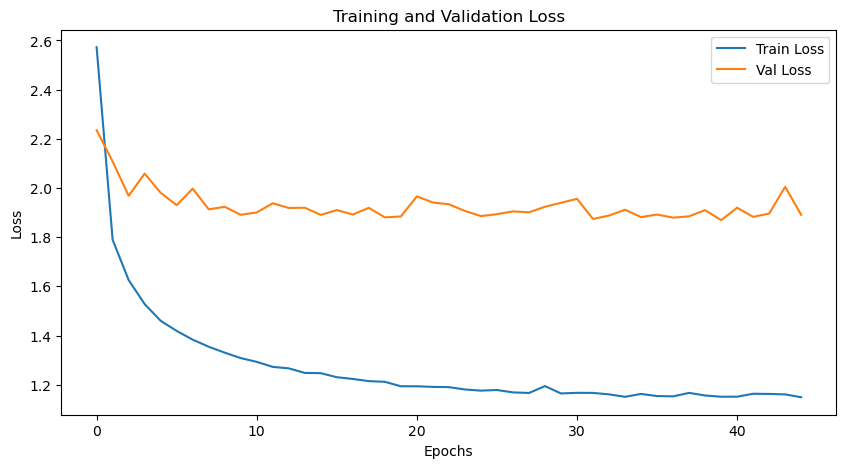

In [12]:
# Plotting training curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

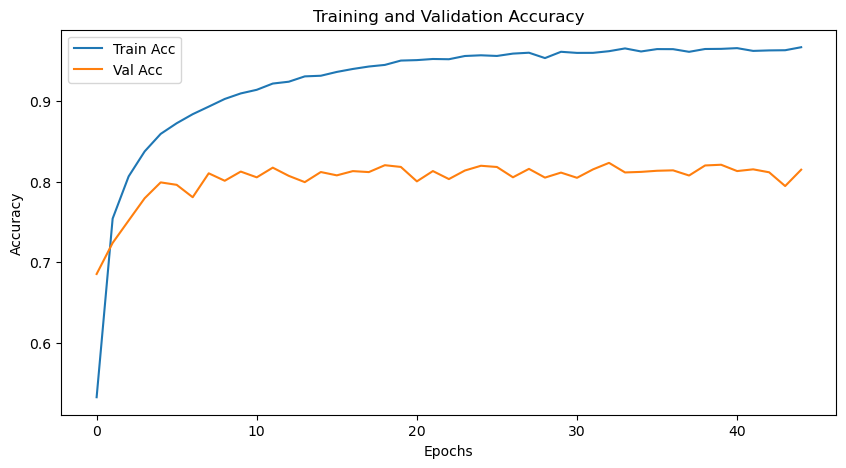

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [14]:
# Load best model
model.load_state_dict(torch.load('vgg19_best_model.pth'))

<All keys matched successfully>

In [15]:
# Testing
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Overall Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Overall Accuracy: 0.8609
Precision: 0.8685
Recall: 0.8609
F1-score: 0.8583


C:\Users\Welcome\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print("train_loss_list = ",train_loss_list)
print("val_loss_list = ", val_loss_list)
print("train_acc_list = ",train_acc_list)
print("val_acc_list = ", val_acc_list)

train_loss_list =  [2.5726423429022502, 1.7892777568829272, 1.6256269385457522, 1.5277873474163013, 1.4598685257554813, 1.4186730196601467, 1.3831438227427908, 1.3544091153792939, 1.330237192043064, 1.308209038594336, 1.2927314840761341, 1.2724789510647503, 1.2663970905070088, 1.2478212655935073, 1.2468184260980044, 1.2303652477926295, 1.2233209923694008, 1.2144576083586491, 1.2117755614380536, 1.1935293107035534, 1.1934309562139251, 1.1910881163965008, 1.1900074246854986, 1.1805893555757556, 1.1757649017111147, 1.1783732599850816, 1.1686838828048793, 1.1662329758020271, 1.1942454888132557, 1.1643006587180187, 1.1669434407599886, 1.1665266859800296, 1.160634887087476, 1.150735356891824, 1.1623575013107204, 1.1537202170572232, 1.1525434258357854, 1.166617554691639, 1.1560717102693918, 1.1510277836222123, 1.151181102212693, 1.1630681465649757, 1.1624268491947976, 1.160526499298696, 1.1490092519530677]
val_loss_list =  [2.235060735028765, 2.10785805479235, 1.9682578531354062, 2.0586340410